# Experiments on Graph-Generative-Models
In this notebook, we aim to evluate the performance of "GDSS" proposed in "Score-based Generative Modeling of Graphs via the System of Stochastic Differential Equations" (https://arxiv.org/pdf/2202.02514.pdf). The baseline model is tested on 3 datasets (Grid, Protein, 3D Point Cloud) and measured under 4 metrics (degree, clustering, orbit, spectral).

It should be noted that we adopt the same datasets presets as in "Efficient Graph Generation with Graph Recurrent Attention Networks" (https://arxiv.org/pdf/1910.00760.pdf), where:
- Grid: 100 graphs are generated with $100\leq |V| \leq 400$;
- Protein: 918 graphs are generated with $100\leq |V| \leq 500$;
- 3D Point-Cloud (FirstMM-DB): 41 graphs are generated with $\bar{|V|} > 1000$

Following the experimental setting as in "GraphRNN: Generating Realistic Graphs with Deep Auto-regressive Models" (https://arxiv.org/abs/1802.08773), we conduct a 80\%-20\% split of the graph samples in each dataset. Then we generate the same size of graph samples as the test dataset and harness the maximum mean discrepancy (MMD) to evaluate the generative graph distribution.

### Experiments on GDSS
Here we immigrate the original terminal-executable GDSS codes into the notebook.

##### Change current directory.

In [1]:
import os
path_DGSS = "./GDSS/"
os.chdir(path_DGSS)

##### Install dependencies

In [ ]:
!pip install -r requirements.txt
!conda install -c conda-forge rdkit=2020.09.1.0
!yes | pip install git+https://github.com/fabriziocosta/EDeN.git --user!

##### Assign dataset and seed

In [2]:
dataset = 'grid'
# dataset = 'DD'
# dataset = 'FIRSTMM_DB'
seed = 42

In [ ]:
!pip install GPUtil

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()                           

##### Generate dataset

In [3]:
!python data/data_generators.py --dataset $dataset

Loading graph dataset: FIRSTMM_DB
56468
126038
Graphs loaded, total num: 24
FIRSTMM_DB 24
995


##### Decide which metric to be used

In [3]:
metric_selection = 'MMD'

if metric_selection == 'EMD':
    from sampler import Sampler, Sampler_mol
    from evaluation.stats import eval_graph_list
    from evaluation.mmd import gaussian, gaussian_emd
else:
    from sampler_new import Sampler, Sampler_mol
    from evaluation.stats_new import eval_graph_list
    import evaluation.mmd_new

##### Train the GDSS model

In [ ]:
import torch
import argparse
import time
from parsers.config import get_config
from trainer import Trainer

os.environ["CUDA_VISIBLE_DEVICES"] = "6,7"
torch.cuda.empty_cache()

ts = time.strftime('%b%d-%H:%M:%S', time.gmtime())
config = get_config(dataset, seed)
trainer = Trainer(config) 
ckpt = trainer.train(ts)
if 'sample' in config.keys():
    config.ckpt = ckpt
    sampler = Sampler(config) 
    sampler.sample()

##### Generate new graphs by the trained GDSS model

In [5]:
import torch
import argparse
import time
from parsers.config import get_config
from trainer import Trainer

os.environ["CUDA_VISIBLE_DEVICES"] = "2,5,6,7"
torch.cuda.empty_cache()

config = get_config(dataset, seed)
ckpt = 'grid_5000'
ckpt = 'DD_1500'
config.ckpt = ckpt
if dataset in ['QM9', 'ZINC250k']:
    sampler = Sampler_mol(config)
else:
    sampler = Sampler(config) 
sampler.sample()

./checkpoints/DD/DD_1500.pth loaded
----------------------------------------------------------------------------------------------------
Make Directory DD/test in Logs
(Reverse)+(Langevin): eps=0.0001 denoise=True ema=True || snr=0.1 seps=0.7 n_steps=1 
----------------------------------------------------------------------------------------------------
GEN SEED: 13


 
Round 0 : 470.73s


 
Round 1 : 471.46s


 
Round 2 : 461.45s


 
Round 3 : 457.31s


 
Round 4 : 457.52s


 
Round 5 : 457.97s


 
Round 6 : 458.96s


 
Round 7 : 458.07s


 
Round 8 : 459.37s


 
Round 9 : 458.35s


 
Round 10 : 461.69s


 
Round 11 : 459.60s


 
Round 12 : 460.15s


 
Round 13 : 462.14s


 
Round 14 : 463.47s


 
Round 15 : 462.20s


 
Round 16 : 462.73s


 
Round 17 : 463.23s


 
Round 18 : 466.30s


 
Round 19 : 464.65s


 
Round 20 : 463.22s


 
Round 21 : 465.90s


 
Round 22 : 470.51s


 
Round 23 : 470.18s


 
Round 24 : 468.69s


 
Round 25 : 468.50s


 
Round 26 : 473.52s


 
Round 27 : 470.69s


 
Round 28 : 471.12s


 
Round 29 : 471.83s


 
Round 30 : 474.90s


 
Round 31 : 471.48s


 
Round 32 : 472.23s


 
Round 33 : 472.24s


 
Round 34 : 476.34s


 
Round 35 : 475.91s


 
Round 36 : 474.72s


 
Round 37 : 474.92s


 
Round 38 : 475.38s


 
Round 39 : 475.14s


 
Round 40 : 474.61s


 
Round 41 : 475.04s


 
Round 42 : 477.46s


 
Round 43 : 478.63s


 
Round 44 : 478.30s


 
Round 45 : 476.18s


 
Round 46 : 480.42s


 
Round 47 : 477.85s


 
Round 48 : 479.93s


 
Round 49 : 477.95s


 
Round 50 : 476.91s


 
Round 51 : 478.99s


 
Round 52 : 479.18s


 
Round 53 : 488.56s


 
Round 54 : 483.99s


 
Round 55 : 482.71s


 
Round 56 : 480.93s


 
Round 57 : 481.68s


 
Round 58 : 481.01s
degree    : 1.016067
cluster   : 1.210041
orbit     : 0.732191
spectral  : 0.307286


##### Load dataset

In [3]:
import pickle
import math

from utils.logger import Logger, set_log, start_log, train_log, sample_log, check_log
from data.data_generators import load_dataset

save_dir = './samples/pkl/grid/test/gdss_grid-sample.pkl'
# save_dir = './samples/pkl/DD/test/DD_500-sample.pkl'
# save_dir = './samples/pkl/DD/test/DD_1000-sample.pkl'
# save_dir = './samples/pkl/DD/test/DD_1500-sample.pkl'
with open(save_dir, 'rb') as f:
    gen_graph_list = pickle.load(f)

test_split = 0.2

graph_list = load_dataset(data_dir='./data', file_name=dataset)
print('Target dataset:' + dataset)
test_size = int(test_split * len(graph_list))
train_graph_list, test_graph_list = graph_list[test_size:], graph_list[:test_size]
print('Length of testing dataset:' + str(len(test_graph_list)))
print('Length of gen dataset:' + str(len(gen_graph_list)))

Target dataset:DD
Length of testing dataset:233
Length of gen dataset:233


##### Plot EV numbers for each sample

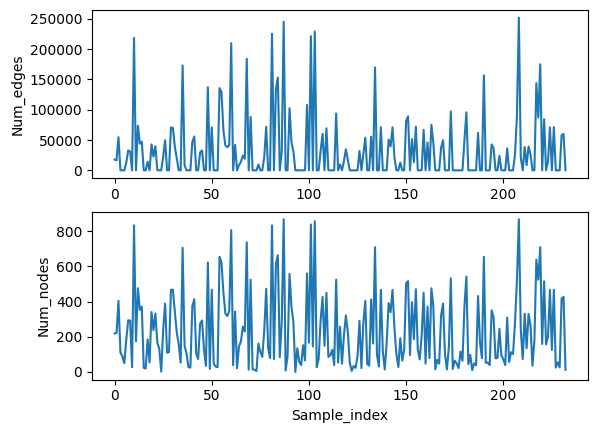

In [6]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def plot_EV_distribution(graphs):
    max_num = len(graphs)
    EV_distribution = np.zeros((max_num,2))
    for idx in range(max_num):
        if not isinstance(graphs[idx], nx.Graph):
            G = graphs[idx].g.copy()
        else:
            G = graphs[idx].copy()
        assert isinstance(G, nx.Graph)
        G.remove_nodes_from(list(nx.isolates(G)))
        e = G.number_of_edges()
        v = G.number_of_nodes()
        l = nx.number_of_selfloops(G)
        EV_distribution[idx,:] = [e-l,v]
        x = G.nodes.data('feature')
    x = range(0,max_num)
    plt.subplot(2, 1, 1)
    plt.plot(x,EV_distribution[:,0])
    plt.ylabel('Num_edges')

    plt.subplot(2, 1, 2)
    plt.plot(x,EV_distribution[:,1])
    plt.ylabel('Num_nodes')
    plt.xlabel('Sample_index')
    plt.show()

plot_EV_distribution(gen_graph_list)

##### Calculate 4 metrics

In [6]:
methods = ['degree', 'cluster', 'orbit', 'spectral'] 
kernels = {}
if metric_selection == 'EMD':
    kernels = {'degree':gaussian_emd, 
                'cluster':gaussian_emd, 
                'orbit':gaussian,
                'spectral':gaussian_emd}
    result_dict = eval_graph_list(test_graph_list, gen_graph_list, methods, kernels)
else:
    result_dict = eval_graph_list(test_graph_list, gen_graph_list)

degree    : 0.41090059
cluster   : 0.34795061
orbit     : 0.81048484
spectral  : 0.43759743


##### Plot Graphs

In [5]:
from utils.plot import plot_graphs_list


plot_graphs_list(graphs=gen_graph_list, title=dataset, max_num=16, save_dir=dataset)

### Exact Likelihood of Graph Models


##### Change current directory

In [1]:
import os

def switchDir(target):
    path_DGSS = "../GDSS/" if "SCORE_SDE" in os.getcwd() else "./GDSS/"
    path_SDE = "../SCORE_SDE/" if "GDSS" in os.getcwd() else "./SCORE_SDE/"
    path = path_DGSS if target in path_DGSS else path_SDE
    os.chdir(path)
    print(os.getcwd())

switchDir("SCORE_SDE")

/mnt/284ac980-b350-4035-8e02-707f671ad89e/hsun409/Experiments-on-Graph-Generative-Models/SCORE_SDE


##### Install dependencies

In [ ]:
!pip install -r requirements.txt

##### Compute likelihood for graph dataset (bits per node)

In [2]:
#@title Autoload all modules
%load_ext autoreload
%autoreload 2

from dataclasses import dataclass, field
import matplotlib.pyplot as plt
import io
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import importlib
import os
import functools
import itertools
import torch
from losses import get_optimizer
from models.ema import ExponentialMovingAverage

import torch.nn as nn
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
# import tensorflow_gan as tfgan
import tqdm
import io
import likelihood
import controllable_generation
from utils import restore_checkpoint
sns.set(font_scale=2)
sns.set(style="whitegrid")

import models
from models import utils as mutils
from models import ncsnv2
from models import ncsnpp
from models import ddpm as ddpm_model
from models import layerspp
from models import layers
from models import normalization
import sampling
from likelihood import get_likelihood_fn
from sde_lib import VESDE, VPSDE, subVPSDE
from sampling import (ReverseDiffusionPredictor, 
                      LangevinCorrector, 
                      EulerMaruyamaPredictor, 
                      AncestralSamplingPredictor, 
                      NoneCorrector, 
                      NonePredictor,
                      AnnealedLangevinDynamics)
import datasets

2022-09-14 15:04:55.826481: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [34]:
sde = 'VESDE' #@param ['VESDE', 'VPSDE', 'subVPSDE'] {"type": "string"}
if sde.lower() == 'vesde':
  from configs.ve import GDSS as configs
  ckpt_filename = "exp/ve/cifar10_ncsnpp_continuous/checkpoint_24.pth"
  ckpt_filename = "/localscratch/hsun409/Experiments-on-Graph-Generative-Models/GDSS/checkpoints/grid/gdss_grid.pthexp/ve/cifar10_ncsnpp_continuous/checkpoint_24.pth"
  config = configs.get_config()  
  sde = VESDE(sigma_min=config.model.sigma_min, sigma_max=config.model.sigma_max, N=config.model.num_scales)
  sampling_eps = 1.0e-4
elif sde.lower() == 'vpsde':
  from configs.vp import cifar10_ddpmpp_continuous as configs  
  ckpt_filename = "exp/vp/cifar10_ddpmpp_continuous/checkpoint_8.pth"
  config = configs.get_config()
  sde = VPSDE(beta_min=config.model.beta_min, beta_max=config.model.beta_max, N=config.model.num_scales)
  sampling_eps = 1e-3
elif sde.lower() == 'subvpsde':
  from configs.subvp import cifar10_ddpmpp_continuous as configs
  ckpt_filename = "exp/subvp/cifar10_ddpmpp_continuous/checkpoint_26.pth"
  config = configs.get_config()
  sde = subVPSDE(beta_min=config.model.beta_min, beta_max=config.model.beta_max, N=config.model.num_scales)
  sampling_eps = 1e-3
batch_size =  8#@param {"type":"integer"}
config.training.batch_size = batch_size
config.eval.batch_size = batch_size

sigmas = mutils.get_sigmas(config)
scaler = datasets.get_data_scaler(config)
inverse_scaler = datasets.get_data_inverse_scaler(config)
score_model = mutils.create_model(config)



In [4]:
import pickle
import math

switchDir("GDSS")

from data.data_generators import load_dataset
dataset = 'grid'
save_dir = './samples/pkl/grid/test/gdss_grid-sample.pkl'

with open(save_dir, 'rb') as f:
    gen_graph_list = pickle.load(f)

test_split = 0.2

graph_list = load_dataset(data_dir='./data', file_name=dataset)
print('Target dataset:' + dataset)
test_size = int(test_split * len(graph_list))
train_graph_list, test_graph_list = graph_list[test_size:], graph_list[:test_size]
print('Length of testing dataset:' + str(len(test_graph_list)))
print('Length of gen dataset:' + str(len(gen_graph_list)))

switchDir("SCORE_SDE")

/mnt/284ac980-b350-4035-8e02-707f671ad89e/hsun409/Experiments-on-Graph-Generative-Models/GDSS
Target dataset:grid
Length of testing dataset:20
Length of gen dataset:20
/mnt/284ac980-b350-4035-8e02-707f671ad89e/hsun409/Experiments-on-Graph-Generative-Models/SCORE_SDE


In [ ]:
# train_ds, eval_ds, _ = datasets.get_dataset(config, uniform_dequantization=True, evaluation=True)
train_ds, eval_ds = train_graph_list, test_graph_list
eval_iter = iter(eval_ds)
bpds = []
likelihood_fn = likelihood.get_likelihood_fn(sde,                                              
                                             inverse_scaler,                                             
                                             eps=1e-5)
for batch in eval_iter:
  shape = (1, batch.number_of_edges(), batch.number_of_nodes())
  # print(config)
  # img = batch['image']._numpy()
  # img = torch.tensor(img).permute(0, 3, 1, 2).to(config.device)
  # img = scaler(img)
  data = batch
  bpd, z, nfe = likelihood_fn(score_model, data)
  bpds.extend(bpd)
  print(f"average bpd: {torch.tensor(bpds).mean().item()}, NFE: {nfe}")